In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from time import time
import matplotlib.pyplot as plt
from operator import itemgetter

# Stop deprecation warnings from being printed
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [17]:
# load data
data = pd.read_csv("sample.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### check null value

In [18]:
#return a formatted percentage from a fraction
def percentage(numerator, denomenator):
    
    if type(numerator) == pd.core.series.Series:
        return (numerator/denomenator*100).map('{:.1f}%'.format)
    
    elif type(numerator) == int or type(numerator) == float:
        return '{:.1f}%'.format(float(numerator)/float(denomenator)*100) 
    
    else:
        print("check type")

In [19]:
percentage(data.count()-1, data.shape[0]-1)

Unnamed: 0         100.0%
Flow ID            100.0%
 Source IP         100.0%
 Source Port       100.0%
 Destination IP    100.0%
                    ...  
 Idle Max          100.0%
 Idle Min          100.0%
SimillarHTTP       100.0%
 Inbound           100.0%
 Label             100.0%
Length: 88, dtype: object

### Formatting Data for Sklearn and Examining RF Algorithm Parameters

In [20]:
data_Y = data[' Label']
data_X = data.drop(columns=['Unnamed: 0', 'Flow ID', ' Timestamp', ' Label'])
del data

In [21]:
src_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in data_X[' Source IP']]
data_X[' Source IP'] = pd.Series(src_ip)

dst_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in data_X[' Destination IP']]
data_X[' Destination IP'] = pd.Series(dst_ip)

# do data_X['SimillarHTTP'].value_counts()
data_X['SimillarHTTP'][data_X['SimillarHTTP'] != 0] = 1      

# todo: scale before preprocessing
data_X['Flow Bytes/s'][np.isinf(data_X['Flow Bytes/s'])] = 9999999999
data_X['Flow Bytes/s'][data_X['Flow Bytes/s'].isna()] = data_X['Flow Bytes/s'].mean()

data_X[' Flow Packets/s'][np.isinf(data_X[' Flow Packets/s'])] = 5000000

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/l

In [22]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.3, random_state=1)

In [23]:
scaler = StandardScaler().fit(train_X)
train_X_std = scaler.transform(train_X)
test_X_std = scaler.transform(test_X)

In [24]:
train_Y_num = train_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()
test_Y_num = test_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

In [25]:
# parameters and ranges to plot
param_grid = {"n_estimators": [50,100],
              #"max_depth": np.arange(1, 28, 1),
              "min_samples_split": [1.0,2],
              "min_samples_leaf": [1,5],
              #"max_leaf_nodes": np.arange(2,60,1),
              #"min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)
             }

### criterion: Gini

#### n_estimator

In [26]:
n_est = [10,50,100,500,1000]
train_score = []
test_score = []

In [27]:
for c in n_est:
    rf = RandomForestClassifier(criterion='gini', n_estimators=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

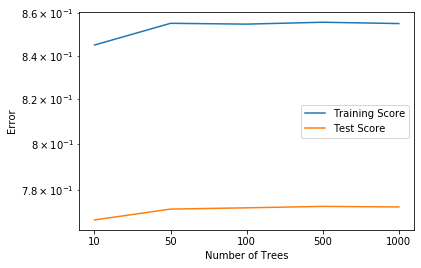

In [28]:
plt.semilogy([1,2,3,4,5], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5], test_score, label="Test Score")
plt.xticks([1,2,3,4,5],n_est)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### max_depth

In [29]:
maxdepth = np.arange(1, 28, 2)
train_score = []
test_score = []
for c in maxdepth:
    rf = RandomForestClassifier(criterion='gini', max_depth=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

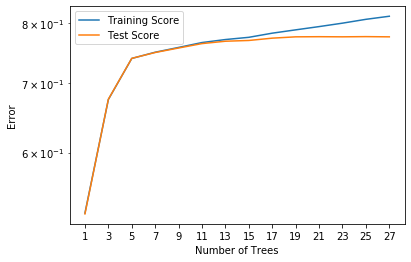

In [30]:
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14], test_score, label="Test Score")
plt.xticks([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14], maxdepth)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### min_samples_split

In [34]:
minsamplessplit = np.arange(2,150,10)
train_score = []
test_score = []
for c in minsamplessplit:
    rf = RandomForestClassifier(criterion='gini', min_samples_split=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

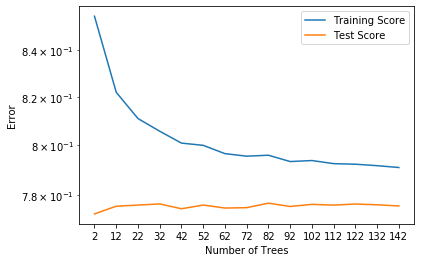

In [35]:
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], test_score, label="Test Score")
plt.xticks([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], minsamplessplit)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### min_samples_leaf

In [36]:
minsamplesleaf = np.arange(1,60,10)
train_score = []
test_score = []
for c in minsamplesleaf:
    rf = RandomForestClassifier(criterion='gini', min_samples_leaf=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

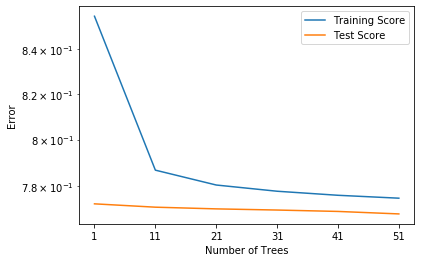

In [37]:
plt.semilogy([1,2,3,4,5,6], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5,6], test_score, label="Test Score")
plt.xticks([1,2,3,4,5,6], minsamplesleaf)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### max_leaf_nodes

In [38]:
maxleafnodes = np.arange(2,60,4)
train_score = []
test_score = []
for c in maxleafnodes:
    rf = RandomForestClassifier(criterion='gini', max_leaf_nodes=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

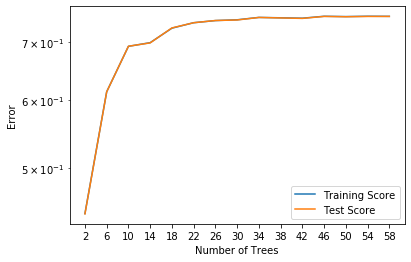

In [39]:
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], test_score, label="Test Score")
plt.xticks([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], maxleafnodes)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### min_weight_fraction_leaf

In [40]:
mwfleaf = np.arange(0.1,0.4, 0.1)
train_score = []
test_score = []
for c in mwfleaf:
    rf = RandomForestClassifier(criterion='gini', min_weight_fraction_leaf=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

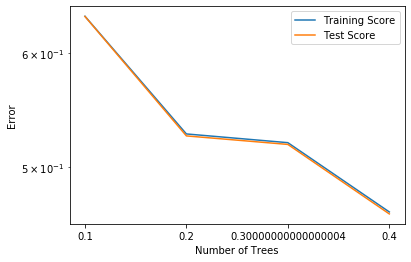

In [41]:
plt.semilogy([1,2,3,4], train_score, label="Training Score")
plt.semilogy([1,2,3,4], test_score, label="Test Score")
plt.xticks([1,2,3,4], mwfleaf)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

entropy

#### n_estimator

In [42]:
n_est = [10,50,100,500,1000]
train_score = []
test_score = []

In [43]:
for c in n_est:
    rf = RandomForestClassifier(criterion='entropy', n_estimators=c).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

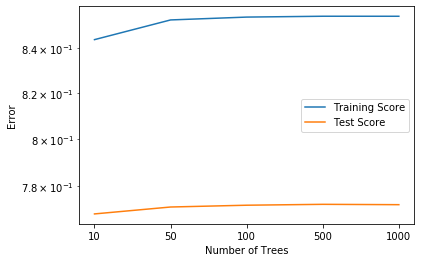

In [44]:
plt.semilogy([1,2,3,4,5], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5], test_score, label="Test Score")
plt.xticks([1,2,3,4,5],n_est)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### max_depth

In [45]:
maxdepth = np.arange(1, 28, 2)
train_score = []
test_score = []
for c in maxdepth:
    rf = RandomForestClassifier(criterion='entropy', max_depth=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

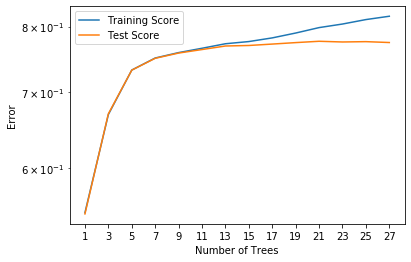

In [46]:
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14], test_score, label="Test Score")
plt.xticks([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14], maxdepth)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### min_samples_split

In [47]:
minsamplessplit = np.arange(2,150,10)
train_score = []
test_score = []
for c in minsamplessplit:
    rf = RandomForestClassifier(criterion='entropy', min_samples_split=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

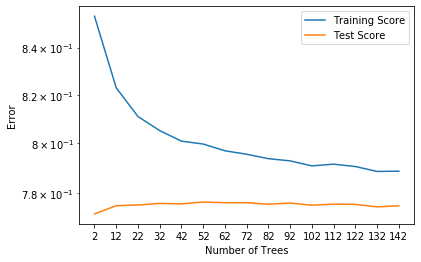

In [48]:
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], test_score, label="Test Score")
plt.xticks([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], minsamplessplit)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### min_samples_leaf

In [49]:
minsamplesleaf = np.arange(1,60,10)
train_score = []
test_score = []
for c in minsamplesleaf:
    rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

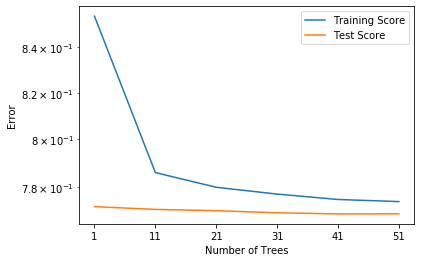

In [50]:
plt.semilogy([1,2,3,4,5,6], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5,6], test_score, label="Test Score")
plt.xticks([1,2,3,4,5,6], minsamplesleaf)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### max_leaf_nodes

In [51]:
maxleafnodes = np.arange(2,60,4)
train_score = []
test_score = []
for c in maxleafnodes:
    rf = RandomForestClassifier(criterion='entropy', max_leaf_nodes=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

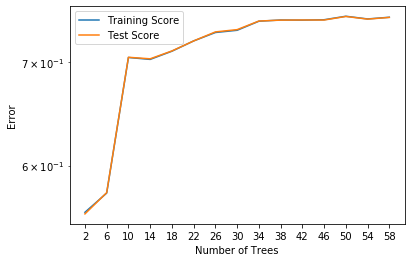

In [52]:
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], train_score, label="Training Score")
plt.semilogy([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], test_score, label="Test Score")
plt.xticks([1,2,3,4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15], maxleafnodes)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

#### min_weight_fraction_leaf

In [53]:
mwfleaf = np.arange(0.1,0.4, 0.1)
train_score = []
test_score = []
for c in mwfleaf:
    rf = RandomForestClassifier(criterion='entropy', min_weight_fraction_leaf=c, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_score.append(rf.score(train_X_std, train_Y_num))
    test_score.append(rf.score(test_X_std, test_Y_num))

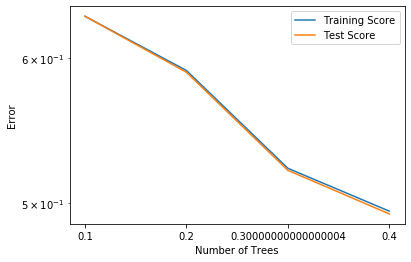

In [54]:
plt.semilogy([1,2,3,4], train_score, label="Training Score")
plt.semilogy([1,2,3,4], test_score, label="Test Score")
plt.xticks([1,2,3,4], mwfleaf)
plt.xlabel('Number of Trees')
plt.ylabel("Error")
plt.legend()
plt.show()

### train using the tuning parameter

In [61]:
rf = RandomForestClassifier(random_state=0, n_estimators=1000, max_depth=28, min_samples_split=12, min_samples_leaf=1,
                            max_leaf_nodes=60, min_weight_fraction_leaf=0.0, criterion="gini")
model = rf.fit(train_X_std, train_Y_num)

In [62]:
rf.score(train_X_std, train_Y_num)

0.7532019417625043

In [63]:
rf.score(test_X_std, test_Y_num)

0.7526965232280356

In [66]:
rf = RandomForestClassifier(random_state=0, n_estimators=1000, max_depth=28, min_samples_split=2, min_samples_leaf=1,
                            max_leaf_nodes=60, min_weight_fraction_leaf=0.0, criterion="gini")
model = rf.fit(train_X_std, train_Y_num)

In [67]:
rf.score(train_X_std, train_Y_num)

0.7532019417625043

In [68]:
rf.score(test_X_std, test_Y_num)

0.7526965232280356

In [78]:
rf = RandomForestClassifier(random_state=0, n_estimators=1000, criterion="entropy")

In [79]:
model = rf.fit(train_X_std, train_Y_num)

In [80]:
rf.score(train_X_std, train_Y_num)

0.8544930446541661

In [81]:
rf.score(test_X_std, test_Y_num)

0.7723129607414926

In [82]:
rf = RandomForestClassifier(random_state=0, n_estimators=1000, criterion="gini")

In [83]:
model = rf.fit(train_X_std, train_Y_num)

In [84]:
rf.score(train_X_std, train_Y_num)

0.8554927074053039

In [85]:
rf.score(test_X_std, test_Y_num)

0.7729460797883794